In [1]:
import gymnasium as gym

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Resize, Grayscale, Compose, ToTensor

from collections import deque

In [3]:
plt.style.use('ggplot')

## Set Configs

In [4]:
# Set the figure size
plt.figure(figsize=(6, 4));

<Figure size 600x400 with 0 Axes>

## Init Env

In [5]:
from ale_py import ALEInterface
ale = ALEInterface()

import ale_py.roms as roms
# roms.__all__ # https://www.gymlibrary.dev/environments/atari/complete_list/

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [6]:
from ale_py.roms import Breakout

ale.loadROM(Breakout)

Game console created:
  ROM file:  /home/muhamuttaqien/miniconda3/envs/deeprl/lib/python3.11/site-packages/AutoROM/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1718444681


In [7]:
env = gym.make("ALE/Breakout-v5", render_mode='human')
env.metadata['render_fps'] = 30

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


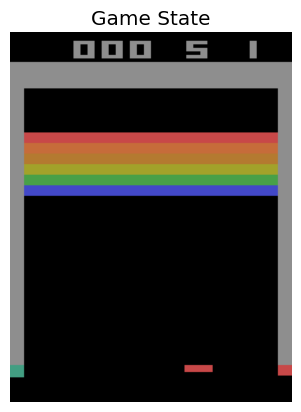

In [8]:
observation, _ = env.reset()

plt.imshow(observation)
plt.title('Game State')
plt.axis('off')
plt.show()

## Utils

In [ ]:
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    return frame / 255.0

In [9]:
def stack_frames(stacked_frames, frame, is_new_episode):
    frame = preprocess_frame(frame)
    if is_new_episode:
        stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for i in range(4)], maxlen=4)
        for _ in range(4):
            stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

## Replay Buffer

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done
    
    def __len__(self):
        return len(self.buffer)

## Build Model

In [35]:
class DQNCNN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQNCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        conv_output_size = self._get_conv_output(input_shape)
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def _get_conv_output(self, shape):
        
        frame = torch.zeros(1, *shape)
        frame = frame.permute(0, 3, 1, 2)

        output = self.conv1(frame)
        print(output)
        output = self.conv2(output)
        output = self.conv3(output)
        return int(np.prod(output.size()))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [36]:
class DQNAgent:
    def __init__(self, env, replay_buffer, gamma=0.99, epsilon_start=1.0, epsilon_end=0.02, epsilon_decay=1000000):
        self.env = env
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_factor = (epsilon_start - epsilon_end) / epsilon_decay
        
        self.model = DQNCNN(env.observation_space.shape, env.action_space.n)
        self.target_model = DQNCNN(env.observation_space.shape, env.action_space.n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.update_target_model()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.model(state).argmax().item()
    
    def train_step(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        
        state = torch.FloatTensor(state)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward)
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor(done)
        
        q_values = self.model(state)
        next_q_values = self.target_model(next_state)
        
        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(1)[0]
        expected_q_value = reward + self.gamma * next_q_value * (1 - done)
        
        loss = nn.MSELoss()(q_value, expected_q_value)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay_factor)

In [37]:
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(env, replay_buffer)

RuntimeError: Given groups=1, weight of size [32, 210, 8, 8], expected input[1, 3, 210, 160] to have 210 channels, but got 3 channels instead

## Train Agent

In [ ]:
def train(env, agent, num_episodes, batch_size, target_update):
    all_rewards = []
    episode_reward = 0
    state = env.reset()
    stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for i in range(4)], maxlen=4)
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    
    for episode in range(num_episodes):
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            
            agent.train_step(batch_size)
            
            if done:
                state = env.reset()
                state, stacked_frames = stack_frames(stacked_frames, state, True)
                all_rewards.append(episode_reward)
                episode_reward = 0
                break
        
        if episode % target_update == 0:
            agent.update_target_model()
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {np.mean(all_rewards[-10:])}")
    
    return all_rewards

In [ ]:
num_episodes = 1000
batch_size = 32
target_update = 10

train(env, agent, num_episodes, batch_size, target_update)

## Run Agent

In [ ]:
observation, info = env.reset()

num_episodes = 20
max_steps_per_episode = 20
rewards_per_episode = [] # List to store collected rewards

while True:
    for episode in range(num_episodes):
        observation = env.reset()
        
        episode_reward = 0  # Total reward for the current episode
    
        for step in range(max_steps_per_episode):
            env.render()
    
            action = env.action_space.sample()
            observation, reward, terminated, truncated, info = env.step(action)
    
            episode_reward += reward  # Accumulate the reward for the episode
    
            if terminated or truncated:
                break  # Exit the inner loop if the episode is terminated
    
        rewards_per_episode.append(episode_reward)  # Store the total reward for the episode

env.close()

---